## Replication of results from paper: "Predicting yeast synthetic lethal genetic interactions using protein domains" 

- Authors: Bo Li, Feng Luo,School of Computing,Clemson University,Clemson, SC, USA
- e-mail: bol, luofeng@clemson.edu
- year:2009

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict 
import seaborn as sns
import matplotlib.cm as cm
import scipy as scipy
import random

In [3]:
## Datasets
data_domains=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\machine-learning-for-yeast\datasets-for-learning\proteins-domains-from-Pfam.xlsx',header=0,index_col='Unnamed: 0')
data_domains=data_domains.dropna()
data_sl=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\machine-learning-for-yeast\datasets-for-learning\data-synthetic-lethals.xlsx',header=0)
data_nonsl=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\machine-learning-for-yeast\datasets-for-learning\data-positive-genetic.xlsx',header=0)



## Building the feature matrix
 One matrix for true SL where each row is one pair of SL. Every raw will be a vector of  0,1 or 2 depending on the comparison with the domain list. For row i the jth element = 0 if the jth element of the domain list is not in neither protein A and B, 1, if it is in one of them and 2 if it is in both of them .  




## Building the list of proteins domains id per protein pair separately :

1. List of protein A: Search for the Sl/nSL database the query gene name and look in the protein domain database which protein domains id has each of those queries.
2. List of protein B: Search for the Sl/nSL database the target gene name of the previous query and look in the protein domain database which protein domains id has each of those target genes.

In [51]:
population = np.arange(0,17871)
print("With list:", random.sample(list(population), 3)) 

With list: [281, 5308, 11778]


In [4]:

# Selecting the meaningful columns in the respective dataset
domain_id_list=data_domains['domain-name']
query_gene=data_sl['gene-query-name']
target_gene=data_sl['gene-target-name']
query_gene_nonlethal=data_nonsl['gene-query-name']
target_gene_nonlethal=data_nonsl['gene-target-name']



# Initialising the arrays
protein_a_list=[]
protein_b_list=[]
protein_a_list_non=[]
protein_b_list_non=[]

population = np.arange(0,len(data_sl))

# For loop for 10000 pairs sampled randomly from the SL/nSl pair list , and creating a big array of proteind domains id per protein pair
for m in random.sample(list(population), 10000):
    protein_a=data_domains[data_domains['name']==query_gene[m]]
    protein_b=data_domains[data_domains['name']==target_gene[m]]
    protein_a_list.append(protein_a['domain-name'].tolist())
    protein_b_list.append(protein_b['domain-name'].tolist())

    protein_a_non=data_domains[data_domains['name']==query_gene_nonlethal[m]]
    protein_b_non=data_domains[data_domains['name']==target_gene_nonlethal[m]]
    protein_a_list_non.append(protein_a_non['domain-name'].tolist())
    protein_b_list_non.append(protein_b_non['domain-name'].tolist())
    

In [5]:
print('We are going to analyze',len((protein_a_list)) ,'protein pairs, out of',len(data_sl),'SL protein pairs')

We are going to analyze 10000 protein pairs, out of 17871 SL protein pairs


## removed protein pairs from study if either protein in the pair does not contain any domain

In [6]:
def remove_empty_domains(protein_list_search,protein_list_pair):
    index=[]
    for i in np.arange(0,len(protein_list_search)):
        if protein_list_search[i]==[]:
            index.append(i) ## index of empty values for the protein_a_list meaning they dont have any annotated domain

    y=[x for x in np.arange(0,len(protein_list_search)) if x not in index] # a list with non empty values from protein_a list

    protein_list_search_new=[]
    protein_list_pair_new=[]
    for i in y:
        protein_list_search_new.append(protein_list_search[i])
        protein_list_pair_new.append(protein_list_pair[i])
    return protein_list_search_new,protein_list_pair_new

## evaluating the function

protein_a_list_new,protein_b_list_new=remove_empty_domains(protein_a_list,protein_b_list)
protein_a_list_non_new,protein_b_list_non_new=remove_empty_domains(protein_a_list_non,protein_b_list_non)

In [7]:
print('The empty domain in the SL were:', len(protein_a_list)-len(protein_a_list_new), 'out of', len(protein_a_list),'domains')

print('The empty domain in the nSL were:', len(protein_a_list_non)-len(protein_a_list_non_new), 'out of', len(protein_a_list_non),'domains')

The empty domain in the SL were: 684 out of 10000 domains
The empty domain in the nSL were: 675 out of 10000 domains


## Select from each ordered indexes of  domain id list which of them appear once, in both or in any of the domains of each protein pair

In [8]:
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y] # a function that give the index of whether a value appear in array or not
a=[1,2,2,4,5,6,7,8,9,10]
get_indexes(2,a)

[1, 2]

In [9]:
def feature_building(protein_a_list_new,protein_b_list_new):
    x = np.unique(domain_id_list)
    protein_feat_true=np.zeros(shape=(len(x),len(protein_a_list_new)))
    pair_a_b_array=[]
    for i in np.arange(0,len(protein_a_list_new)):
        index_a=[]
        pair=[protein_a_list_new[i],protein_b_list_new[i]]
        pair_a_b=np.concatenate(pair).ravel()
        pair_a_b_array.append(pair_a_b)

    for i in np.arange(0,len(pair_a_b_array)):  
        array,index,counts=np.unique(pair_a_b_array[i],return_index=True,return_counts=True)
        for k,m in zip(counts,array):
            if k ==2:
                protein_feat_true[get_indexes(m,x),i]=2
                
            if k==1:
                protein_feat_true[get_indexes(m,x),i]=1
            # print(index_a[m],i)
    return protein_feat_true

In [10]:
protein_feat_true=feature_building(protein_b_list_new=protein_b_list_new,protein_a_list_new=protein_a_list_new)
protein_feat_true_pd=pd.DataFrame(protein_feat_true.T)

protein_feat_non_true=feature_building(protein_b_list_new=protein_b_list_non_new,protein_a_list_new=protein_a_list_non_new)

protein_feat_non_true_pd=pd.DataFrame(protein_feat_non_true.T)
# stats_lethals=protein_feat_true_pd.describe()
# stats_lethals.index

In [11]:
index_2_true=protein_feat_true_pd.where(protein_feat_true_pd==2)
index_2_true_count=index_2_true.count(axis=1).sum()

index_1_true=protein_feat_true_pd.where(protein_feat_true_pd==1)
index_1_true_count=index_1_true.count(axis=1).sum()

index_2_nontrue=protein_feat_non_true_pd.where(protein_feat_non_true_pd==2)
index_2_nontrue_count=index_2_nontrue.count(axis=1).sum()

index_1_nontrue=protein_feat_non_true_pd.where(protein_feat_non_true_pd==1)
index_1_nontrue_count=index_1_nontrue.count(axis=1).sum()


print('fraction of twos in the SL array is',index_2_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns)))
print('fraction of ones in the SL array is',index_1_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns)))
print('fraction of twos in the PI array is',index_2_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns)))
print('fraction of ones in the PI array is',index_1_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns)))

fraction of twos in the SL array is 5.436306150619746e-05
fraction of ones in the SL array is 0.0008958904790123807
fraction of twos in the PI array is 5.1261826158243416e-05
fraction of ones in the PI array is 0.0007972880154210888


([0, 1, 2, 3], <a list of 4 Text xticklabel objects>)

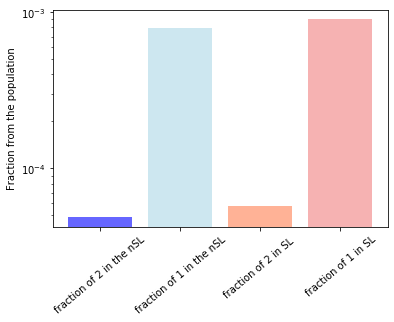

In [16]:
plt.bar(['fraction of 2 in the nSL','fraction of 1 in the nSL'],[index_2_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns)),index_1_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns))],alpha=0.6,color=['blue','lightblue']), 

plt.bar(['fraction of 2 in SL ','fraction of 1 in SL'],[index_2_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns)),index_1_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns))],alpha=0.6,color=['coral','lightcoral'])

plt.ylabel('Fraction from the population')
plt.yscale('log')
plt.xticks(rotation=40)

In [12]:
protein_feat_true_pd['lethality']=np.ones(shape=(len(protein_a_list_new)))
protein_feat_non_true_pd['lethality']=np.zeros(shape=(len(protein_a_list_non_new)))

In [13]:
feature_post=pd.concat([protein_feat_true_pd,protein_feat_non_true_pd],axis=0)

In [14]:
feature_post=feature_post.set_index(np.arange(0,len(protein_a_list_new)+len(protein_a_list_non_new)))

## Load postprocessed data in the shape of the feature matrix 

```Warning```: **Takes a lot of time to load**

In [ ]:
feature_post=pd.read_excel('feature-matrix-positive-vs-SL-domains.xlsx',index_col='Unnamed: 0')

In [15]:
#feature_post=pd.read_excel('feature-matrix.xlsx',index_col='Unnamed: 0')
np.shape(feature_post)

(18641, 3026)

In [16]:
mean=feature_post.T.describe().loc['mean']
std=feature_post.T.describe().loc['std']
lethality=feature_post['lethality']



In [66]:
np.shape(protein_feat_true_pd)[0]

9330

In [17]:
corr_keys=pd.concat([mean,std,lethality],axis=1)

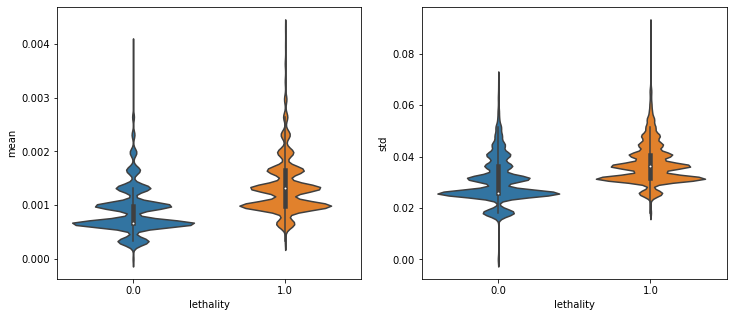

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
sns.violinplot(x="lethality", y="mean", data=corr_keys,ax=axs[0])
sns.violinplot(x="lethality", y="std", data=corr_keys,ax=axs[1])

In [19]:
a=scipy.stats.pearsonr(corr_keys['mean'],corr_keys['lethality'])
p_value_corr=defaultdict(dict)

columns=['mean','std']
for i in columns:
    
    tmp=scipy.stats.pearsonr(corr_keys[i],corr_keys['lethality'])
    p_value_corr[i]['corr with lethality']=tmp[0]
    p_value_corr[i]['p-value']=tmp[1]

p_value_corr_pd=pd.DataFrame(p_value_corr)
#p_value_corr_pd.to_csv('p-value-and-corr.csv')
p_value_corr_pd

,mean,std
corr with lethality,0.421812,0.376791
p-value,0.000000,0.000000


In [20]:
corr_keys.corr()

,mean,std,lethality
mean,1.000000,0.926401,0.421812
std,0.926401,1.000000,0.376791
lethality,0.421812,0.376791,1.000000


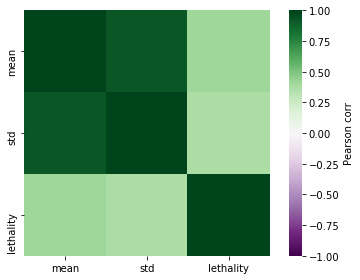

In [21]:
corr = corr_keys.corr()
sns.heatmap(corr, vmax=1,vmin=-1 ,square=True,cmap=cm.PRGn,cbar_kws={'label':'Pearson corr'})
plt.tight_layout()

In [ ]:
# data_all.to_excel('feature-matrix-all.xlsx')

In [ ]:
############## Read the data ############################

# data_all=pd.read_excel('feature-matrix-all.xlsx')

In [22]:
X, y = feature_post.drop(columns=["lethality"]), feature_post["lethality"]


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size = 0.3, random_state= 0)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (13048, 3025) (13048,)
Test set: (5593, 3025) (5593,)


## choosing the best SVM model

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': ['auto','scale']}]
search = GridSearchCV(SVC(), parameters, n_jobs=-1, verbose=1)
search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 36.7min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': ['auto', 'scale'],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [16]:
best_parameters = search.best_estimator_
print(best_parameters)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


### Training with the "best model"

In [75]:
from sklearn import svm

clf = svm.SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8242131616595136

### Saving the model 

In [99]:
from joblib import dump, load
dump(clf, '../model_SVC.joblib') 

['model_SVC.joblib']

### Loading the model 

In [24]:
from joblib import dump, load
clf = load('model_SVC.joblib') 

### Making predictions

In [25]:
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import jaccard_score

y_pred = clf.predict(X_test)

# print('Train set Accuracy: ', metrics.accuracy_score(y_train, clf.predict(X_train)))
print('The mean squared error is =',metrics.mean_squared_error(y_test,y_pred))
print('Test set Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('The Jaccard index is =', jaccard_score(y_test, y_pred))
# Jaccard similarity coefficient, defined as the size of the intersection divided by the size of the union of two label sets. The closer to 1 the better the classifier 
print('The log-loss is =',log_loss(y_test,y_pred))
# how far each prediction is from the actual label, it is like a distance measure from the predicted to the actual , the classifer with lower log loss have better accuracy
print('The f1-score is =',metrics.f1_score(y_test,y_pred))
# The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal.



The mean squared error is = 0.11013767209011265
Test set Accuracy:  0.8898623279098874
The Jaccard index is = 0.801354401805869
The log-loss is = 3.8040647478041025
The f1-score is = 0.8897243107769424


In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['class-0','class-1']))

precision    recall  f1-score   support

     class-0       0.89      0.89      0.89      2802
     class-1       0.89      0.89      0.89      2791

    accuracy                           0.89      5593
   macro avg       0.89      0.89      0.89      5593
weighted avg       0.89      0.89      0.89      5593



In [95]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score
n_samples = X.shape[0]
cv=StratifiedKFold(n_splits=5)
#cross_val_score(clf, X, y, cv=cv)

In [20]:
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_predict


predicted = cross_val_predict(clf, X, y, cv=cv)



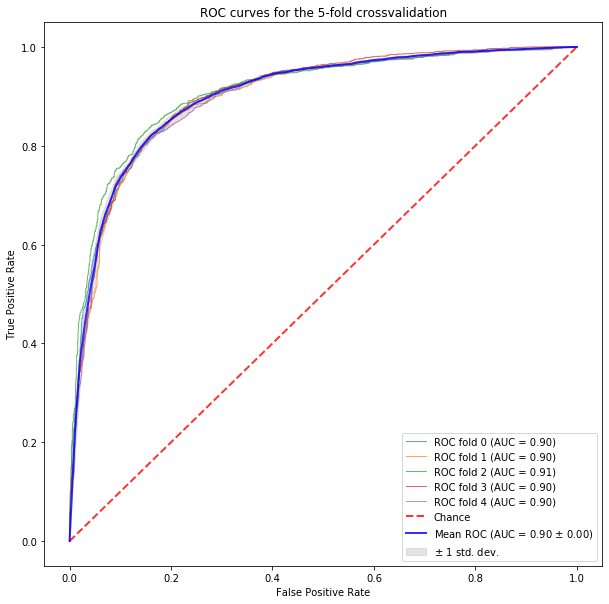

In [96]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

X_0=np.array(X)
y_0=np.array(y)
fig, ax = plt.subplots(figsize=(10,10))
for i, (train, test) in enumerate(cv.split(X_0, y_0)):
    clf.fit(X_0[train], y_0[train])
    viz = plot_roc_curve(clf, X_0[test], y_0[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.7, lw=1, ax=ax)
    interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curves for the 5-fold crossvalidation")
ax.legend(loc="lower right")
plt.savefig('ROC-5-fold-crossvalidation-paper-replication.png',format='png',dpi=300,transparent=True)

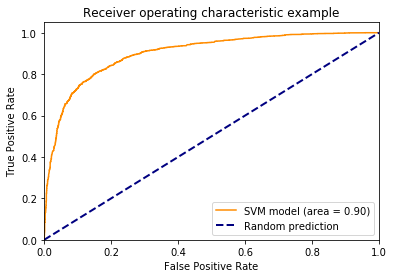

In [81]:
import sklearn.metrics as metrics
scores=clf.decision_function(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)
area=metrics.auc(fpr,tpr)
plt.plot(fpr,tpr,color='darkorange',label='SVM model (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random prediction')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
#plt.savefig('output-images/ROC-curve-SVC-on-classifing-lethality-using-PI-SL.png',format='png',dpi=300,transparent=False)

Text(0.5, 257.44, 'Predicted label')

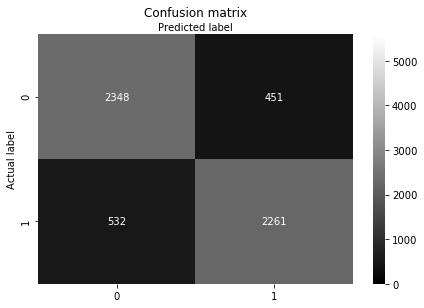

In [82]:
class_names=[1,2,3]
fig, ax = plt.subplots()
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

cm = confusion_matrix(y_test, y_pred)

class_names=['SL', 'nSL']

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cm), annot=True, cmap="gray" ,fmt='g',vmin=0,vmax=len(y_test))
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


Precision ($P$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false positives($F_p$).

$P=\frac{T_p}{T_p+F_p}$

Recall ($R$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false negatives($F_n$).

$R=\frac{T_p}{T_p+F_n}$

In [28]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.889087656529517
Recall: 0.8903618774632748


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.90')

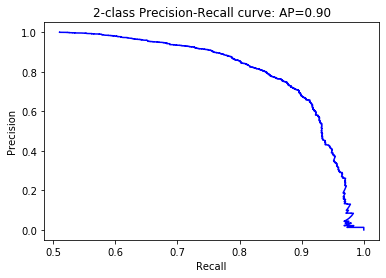

In [84]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, scores)
average_precision = metrics.average_precision_score(y_test, scores)
plt.plot(precision,recall,color='blue')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


print(classification_report(y_test, y_pred))

## Feature importance

First of all, I assume that you call features the variables and not the samples/observations. In this case, you could do something like the following by creating a biplot function that shows everything in one plot. In this example I am using the iris data.

Before the example, please note that the basic idea when using PCA as a tool for feature selection is to select variables according to the magnitude (from largest to smallest in absolute values) of their coefficients (loadings). See my last paragraph after the plot for more details.

PART1: I explain how to check the importance of the features and how to plot a biplot.

PART2: I explain how to check the importance of the features and how to save them into a pandas dataframe using the feature names.





### Data transformation

In [85]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x=X
X_sc = sc_X.fit_transform(x)


In [86]:
from sklearn.decomposition import PCA
pca = PCA() 
X_pca = pca.fit_transform(X_sc)

total=sum(pca.explained_variance_)
k=0
current_variance=0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k=k+1
print(k)

1585


In [88]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
np.random.seed(0)

# 10 samples with 5 features
#train_features = np.random.rand(10,5)
train_features=X_sc
model = PCA(n_components=1585).fit(train_features)
## apply dimensionality reduction to X_train
X_pc = model.transform(train_features)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = X.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())

In [89]:
a=y[df.iloc[:,1]]
df['lethality']=a.values
np.where(a.values==0)

print('The stadistics of the labelled data is:', feature_post['lethality'].value_counts())
print('The number of SL in the reduced set is =',len(np.where(a.values==1)[0]))
print('The number of non SL in the reduced set is =',len(np.where(a.values==0)[0]))

The stadistics of the labelled data is: 1.0    9330
0.0    9308
Name: lethality, dtype: int64
The number of SL in the reduced set is = 1585
The number of non SL in the reduced set is = 0


In [91]:

duplicted_features=df[df.iloc[:,1].duplicated()]

print('The most important features are', len(duplicted_features),'out of ',k,'Principal Components of the data')

The most important features are 636 out of  1585 Principal Components of the data


In [92]:
important_features=pd.DataFrame()

important_features['domain-name']=data_domains['domain-name'][duplicted_features.iloc[:,1]] 
important_features['domain-description']=data_domains['domain-descrip'][duplicted_features.iloc[:,1]] 

In [93]:
important_features

,domain-name,domain-description
930,PF12271,Chs3p; Chitin synthase III catalytic subunit
2430,PF00046,Homeobox; Homeobox domain
2362,PF00155,"Aminotran_1_2; Aminotransferase, class I/classII"
1179,PF10303,DUF2408; Uncharacterised protein family UPF0662
392,PF00710,"Asparaginase; L-asparaginase, N-terminal"
...,...,...
172,PF06999,Suc_Fer-like; Thioredoxin-like ferredoxin
1360,PF00400,WD40; WD40 repeat
645,PF00271,"Helicase_C; Helicase, C-terminal"
1061,PF00674,DUP; Yeast membrane protein DUP/COS


## Learning model using Logistic regression:

- for getting probabilistic results
- to get a linear decision boundary
- to understand the impact of a feature

In [ ]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size = 0.3, random_state= 0)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)